# **Measuring the pupillary light reflex with a Pupil Core headset**
This notebook explores some functionality of the Pupil Core system and shows how, in principle, we can use it to measure the pupil's light reflex and get accurate time-critical measures (e.g. latency to constrict, time-to-peak constriction) using the World Camera to detect light onset. To accomplish this we will need to make use of the Pupil Labs Network API, which uses **ZeroMQ** and **MessagePack** for fast and reliable communication. ZeroMQ (https://zeromq.org/) is an open source universal messaging library and MessagePack (https://msgpack.org/index.html) is a binary format for computer data interchange, like JSON but faster and more efficient.

To begin, make sure the tracker is plugged in and start the **Pupil Capture** real time application (download the latest version here: https://docs.pupil-labs.com/core/). Now we can can import zmq and and set up the Pupil Remote helper, which uses ZeroMQs REQ-REP (request-reply) pattern for reliable one-to-one communication. Pupil Remote accepts requests via a REP socket, which by default is on port 50020 (use the --port application argument to provide a custom port).

In [2]:
from time import sleep, time

from IPython.display import Image
import numpy as np
import pandas as pd
import msgpack
import zmq

# set up zmq context and remote helper for tracker
context = zmq.Context()
address = '127.0.0.1'  # remote ip or localhost
request_port = "50020"  # same as in the pupil remote gui
pupil_remote = zmq.Socket(context, zmq.REQ)
pupil_remote.connect("tcp://{}:{}".format(address, request_port))

With Pupil Remote we can issue the following basic commands:

```Python
'R' # start recording with auto generated session name
'R rec_name' # start recording named "rec_name" 
'r' # stop recording
'C' # start currently selected calibration
'c' # stop currently selected calibration
'T 1234.56' # resets current Pupil time to given timestamp
't' # get current Pupil time; returns a float as string.
'v' # get the Pupil Core software version string
'PUB_PORT' # return the current pub port of the IPC Backbone
'SUB_PORT' # return the current sub port of the IPC Backbone
```
For example, the following code would start a recording, perform a calibration, wait for 40 seconds, and then stop the recording. 

In [7]:
pupil_remote.send_string('R our_recording')
print(pupil_remote.recv_string())

pupil_remote.send_string('C')
print(pupil_remote.recv_string())

sleep(40)

pupil_remote.send_string('r')
print(pupil_remote.recv_string())

OK
OK
OK


Note that we need to receive the response for every command we send to Pupil Remote, otherwise Pupil Capture may become unresponsive. The recording just made will now be saved in the folder specified in Pupil Capture (Recorder>>Path to recordings), in a subfolder named 'our_recording' (use a leading / to start a new path from root). To view the recording, just launch **Pupil Player** and drop in the folder. For a script demonstrating a more complete interaction with Pupil Remote, see here: https://github.com/pupil-labs/pupil-helpers/blob/master/python/pupil_remote_control.py

### **Accessing data in real-time with the IPC Backbone**

If we want to get real-time access to the data generated by Pupil Capture we will need to access the **IPC Backbone**, which is a MessagePack-based API that uses ZeroMQ's PUB-SUB (publish-subscribe) pattern for one-to-many communication. The IPC Backbone is basically a message relay station that runs as a thread in the main process. To tap into the IPC Backbone we will need both the IP address and the session's unique port. These can be requested from Pupil Remote as follows:

In [23]:
# Request 'SUB_PORT' for reading data
pupil_remote.send_string('SUB_PORT')
sub_port = pupil_remote.recv_string()

# Request 'PUB_PORT' for writing data
pupil_remote.send_string('PUB_PORT')
pub_port = pupil_remote.recv_string()

Now, to read data from the IPC Backbone we must *subscribe* to the *topic* we are interested in. All messages on the IPC Backbone are multipart messages which contain (at least) two message frames:

- Frame 1 - contains the topic string (e.g. pupil.1.3d)

- Frame 2 - contains the actual message, which is a msgpack-encoded key-value mapping. Pupil Labs uses msgpack as the serializer due to its efficient format (45% smaller than json, 200% faster than ujson) and because encoders exist for most languages

Let's subscribe to the pupil data and receive a single message. Note that here we use msgpack for serialization of the data.

In [12]:
subscriber = context.socket(zmq.SUB)
subscriber.connect(f'tcp://{address}:{sub_port}')
subscriber.subscribe('pupil.1.3d')  # receive all pupil messages

for msg in range(1):
    topic, payload = subscriber.recv_multipart()
    message = msgpack.loads(payload)
    print(f"{topic}: {message}")

b'pupil.1.3d': {b'circle_3d': {b'center': [-6.062727024239404, 7.2573373425476015, 76.67020568315203], b'normal': [-0.4862393024567709, -0.179596194083497, -0.8551704788035399], b'radius': 1.7197839210140726}, b'confidence': 0.8328064573022729, b'timestamp': 72800.4434, b'diameter_3d': 3.4395678420281453, b'ellipse': {b'center': [111.09635676517327, 178.74291486962085], b'axes': [23.059201044972536, 27.97707914059222], b'angle': 11.253623906156577}, b'location': [111.09635676517327, 178.74291486962085], b'diameter': 27.97707914059222, b'sphere': {b'center': [-0.22785539475815286, 9.412491671549565, 86.93225142879452], b'radius': 12.0}, b'projected_sphere': {b'center': [158.37493746649633, 187.1298021211465], b'axes': [171.1677743925462, 171.1677743925462], b'angle': 90.0}, b'model_confidence': 0.7356920439193004, b'model_id': 1, b'model_birth_timestamp': 72765.503835, b'theta': 1.390220371094368, b'phi': -2.0877981403098818, b'norm_pos': [0.34717611489116645, 0.2552378547099131], b'top

Here is a more intelligible breakdown of the pupil datum that we just recieved and printed above (from https://docs.pupil-labs.com/developer/core/overview/#pupil-datum-format):

```Python
{
    # pupil datum
    'topic': 'pupil.0', 
    'method': '3d c++',
    'norm_pos': [0.5, 0.5],  # norm space, [0, 1]
    'diameter': 0.0,  # 2D image space, unit: pixel
    'timestamp': 535741.715303987,  # time, unit: seconds
    'confidence': 0.0,  # [0, 1]
    
    # 2D ellipse of the pupil in image coordinates
    'ellipse': {  # image space, unit: pixel
        'angle': 90.0,  # unit: degrees
        'center': [320.0, 240.0],
        'axes': [0.0, 0.0],
    },
    'id': 0,  # eye id, 0 or 1
    
    ## 3D model data
    # -1 means that the model is building up and has not finished fitting
    'model_birth_timestamp': -1.0,
    'model_confidence': 0.0,
    'model_id': 1,
    
    # pupil polar coordinates on 3D eye model. The model assumes a fixed
    # eye ball size. Therefore there is no `radius` key
    'theta': 0,
    'phi': 0,
    
    # 3D pupil ellipse
    'circle_3d': {  # 3D space, unit: mm
        'normal': [0.0, -0.0, 0.0],
        'radius': 0.0,
        'center': [0.0, -0.0, 0.0],
    },
    'diameter_3d': 0.0,  # 3D space, unit: mm
    
    # 3D eye ball sphere
    'sphere': {  # 3D space, unit: mm
        'radius': 0.0,
        'center': [0.0, -0.0, 0.0],
    },
    'projected_sphere': {  # image space, unit: pixel
        'angle': 90.0,
        'center': [0, 0],
        'axes': [0, 0],
    },
}
```

The Pupil Core system generates pupil data from eye camera images. It starts by fitting an ellipse to the pupil image and then calculating the diameter of the ellipse in 2d pixel units. This measure, reported as the **diameter** variable, is two-dimensional and therefore sensitive to changes in gaze perspective (e.g. the pupil forshortening error: https://pubmed.ncbi.nlm.nih.gov/25953668/). In addition to the pupil **topic** and the **timestamp** (which get inherited from the eye image), the fields **norm_pos** and **confidence** are also added. The former is the pupil's location in normalised eye coordinates and the latter is a value between 0 and 1 indicating the quality of the measurement.

By default, the Pupil Core software uses the 3d detector for pupil detection. This is an extension of the 2d detector, so its data contains keys that were inherited from the 2d detection, as well as new keys specific to the 3d model. Pupil size measurements using the 3d detection mode are valid without correction for perspective, and the best quoted error is 0.01 mm for a pupil with *r* = 5 mm. Further details on the techspecs can be found here.

- https://perceptual.mpi-inf.mpg.de/files/2018/04/dierkes18_etra.pdf
- https://arxiv.org/abs/1405.0006

Section 3.2 of the first paper discusses the 3d eye model and Section 4.3 talks about pupil size estimation. To see the 3-d model in action, open Pupil Capture and go to one of the eye windows. On the "Settings" tab change the mode to "Algorithm", and then on the "Pupil Detector 3D" tab click "Open Debug Window". You should see something that looks like this:

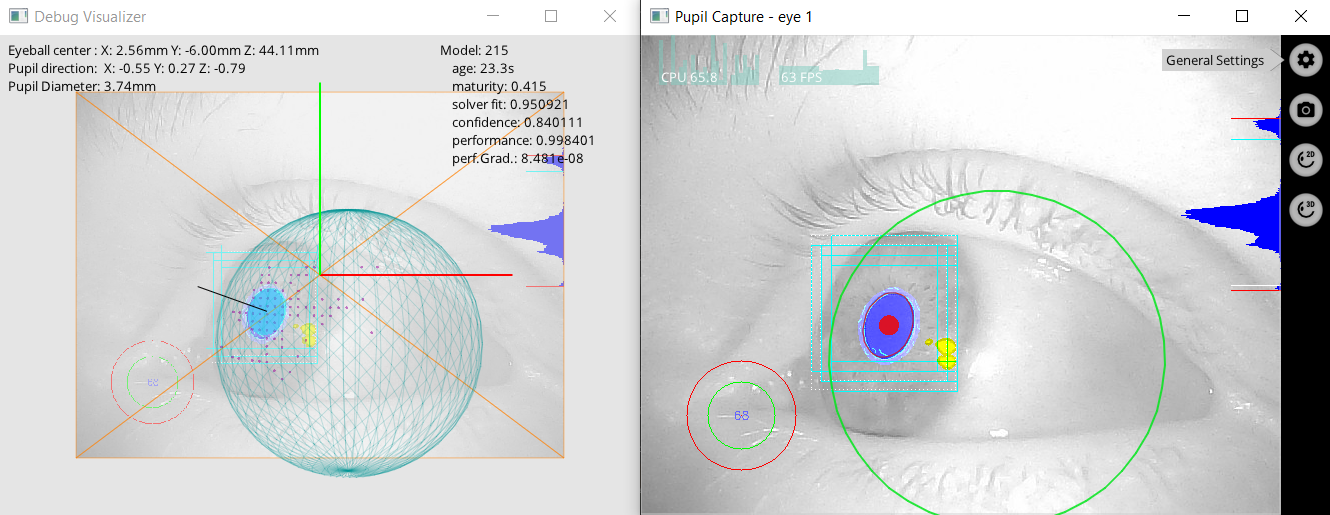

In [5]:
Image("../../../img/CAPTURE.PNG", width=1000)

### **Annotations and notifications**
To extract our experimental events and calculate time-critical measures of the pupil's light response (e.g. constriction latency, time-to-peak constriction) we will need a reliable indication in the pupil data of the time at which a light stimulus was actually administered. Pupil Labs has an **Annotation Capture** plugin that can help us with this. The plugin allows timestamps to be marked with a label, which is basically the same as sending 'messages' or 'triggers'. The labels can be created by pressing customised hotkeys in Pupil Capture or they can be created programmatically and sent to Pupil Capture via the Pupil Core Network API. If our light stimulus could be controlled programmatically and with good timing then we would be able mark the onset and offset of the light within the Pupil recording just by sending an annotation immediately before or after we issue a command to change the status of the light. To do this, we need to start the Annotation Capture plugin, either by clicking on it in Pupil Capture, or by sending a **notification**. Notifications are special messages that Pupil uses to coordinate activities. They are key-value mappings with a required 'subject' field:

```Python
notify.<notification subject>
```

For example:
```Python
# message topic:
'notify.start_plugin.Annotation_Capture'
# message payload, a notification dict
{'subject':'recording.start_plugin', 'name':'Annotation_Capture'}
```

Notifications get passed to all active plugins via the `.on_notify()` callback. To find out which plugins send and receive notifications, open the Pupil codebase and search for `.notify_all(` and `def on_notify(`. Let's define a function that will send notifications and use it to start the Annotation Capture plugin. The same function will come in handy for general communication with Pupil Capture. 

In [9]:
def notify(pupil_remote, notification):
    """Sends ``notification`` to Pupil Remote"""
    topic = "notify." + notification["subject"]
    payload = msgpack.dumps(notification, use_bin_type=True)
    pupil_remote.send_string(topic, flags=zmq.SNDMORE)
    pupil_remote.send(payload)
    return pupil_remote.recv_string()

# start the Annotation Capture plugin
notify(pupil_remote, {"subject": "start_plugin", "name": "Annotation_Capture", "args": {}})

'Message forwarded.'

Now we just need functions to create and send the annotations / triggers / event markers / whatever we want to call them.

In [6]:
def send_trigger(trigger):
    payload = msgpack.dumps(trigger, use_bin_type=True)
    pub_socket.send_string(trigger["topic"], flags=zmq.SNDMORE)
    pub_socket.send(payload)
    
def new_trigger(label, duration):
    return {
        "topic": "annotation",
        "label": label,
        "timestamp": time(),
        "duration": duration
    }

Now, using the functions defined above, let's do a short recording where we send 10 messages a couple of seconds apart. Note that, before starting recording, we need to set Pupil Capture's time to the time of this script. This example is based on a more complete example here: https://github.com/pupil-labs/pupil-helpers/blob/master/python/remote_annotations.py

In [7]:
pub_socket = zmq.Socket(context, zmq.PUB)
pub_socket.connect("tcp://{}:{}".format(address, pub_port))

# set Pupil Capture's time base to the same time as this script (should be done before starting the recording)
pupil_remote.send_string("T {}".format(time()))
print(pupil_remote.recv_string())
    
pupil_remote.send_string('R our_recording')
print(pupil_remote.recv_string())

our_events = []
for event in range(10):
    sleep(2)
    trigger = new_trigger(label='our_event', duration=.1)
    send_trigger(trigger)
    our_events.append(time())
    print("Our event at: {}".format(our_events[-1]))
    
sleep(2)

pupil_remote.send_string('r')
print(pupil_remote.recv_string())

our_events = pd.Series(our_events)

Timesync successful.
OK
Our event at: 1592300706.7236795
Our event at: 1592300708.7239833
Our event at: 1592300710.7252498
Our event at: 1592300712.7253377
Our event at: 1592300714.7269917
Our event at: 1592300716.7287822
Our event at: 1592300718.7298121
Our event at: 1592300720.7302544
Our event at: 1592300722.7311578
Our event at: 1592300724.7323549
OK


If we now find this recording and drop it into Pupil Player, making sure the **Annotation Player** plugin is active, the software will print the messages to the screen during playback. And if we export the data (press 'e' or click export button) we will have a .csv file containing our annotations. 

In [9]:
annotations = pd.read_csv(r"C:\Users\engs2242\recordings\our_recording\051\exports\000\annotations.csv")
annotations

,index,timestamp,label,duration
0,192,1.592301e+09,our_event,0.1
1,391,1.592301e+09,our_event,0.1
2,589,1.592301e+09,our_event,0.1
3,788,1.592301e+09,our_event,0.1
4,987,1.592301e+09,our_event,0.1
5,1186,1.592301e+09,our_event,0.1
6,1385,1.592301e+09,our_event,0.1
7,1584,1.592301e+09,our_event,0.1
8,1783,1.592301e+09,our_event,0.1
9,1980,1.592301e+09,our_event,0.1


Now we can check the timing difference between the annotation timestamps and our_events.

In [14]:
our_events - annotations["timestamp"]

0    0.000000e+00
1    0.000000e+00
2    0.000000e+00
3    2.384186e-07
4    2.384186e-07
5    0.000000e+00
6    2.384186e-07
7    0.000000e+00
8    0.000000e+00
9    2.384186e-07
dtype: float64

Looks good inititally, but probably worth doing a more thorough test at some point.

### **Using the World Camera to detect light onset**
The process outlined above looks to be reliable and efficient but it assumes no latency on the part of the actual event (e.g. a pulse of light). In our case, we can use the STLAB in asynchronous mode (i.e. with a video file) to precisely control the *duration* of a light stimulus, but we know that the command to start playing the video file will take some time to process. Usually this ranges between 100-200 ms, but it can sometimes be as high as 5 s due to various factors such as hardware, processes, whatever the LIGHT HUB is doing at the time, etc. This means that it will not suffice to simply send an annotation before / after we call `stlab.Device.play_video_file(...)`, as the timestamp will not be a reliable indication of light onset. To extract our events and calculate accurate pupil constriction latencies, which are typically on the order of around 200-250 ms, we will need an efficient means of time-stamping stimulus onset. One possibility is to use the WorldCam to detect the onset of the light stimulus and its associated timestamp. For this, we'll need to use the **Network APIs Frame Publisher**, making sure that the format is set to **bgr**. 

In [14]:
#notify({"subject":"start_plugin","name":"UVC_Source","args":{"exposure_mode":"manual","frame_size": (640, 480),"frame_rate": 60,"name":"Pupil Cam1 ID2"}})
#notify({"subject":"start_plugin","name":"UVC_Source","args":{"frame_size": (640, 480),"frame_rate": 60,"name":"Pupil Cam1 ID2","exposure_mode":"manual"}})
notify({"subject":"frame_publishing.set_format", "format":"bgr"})

'Message forwarded.'

This Frame Publisher publishes WorldCam data in various formats under the topic frame.world. The code above starts the plugin in **bgr** format. Now we need a function that can receive the data in real time, and another function that can poll the world camera for a sudden increase in luminance and send an annotation with the associated timestamp. The ideas for these functions come from here: https://github.com/pupil-labs/pupil-helpers/blob/master/python/recv_world_video_frames.py

In [17]:
def recv_from_sub():
    '''Recv a message with topic, payload.
    Topic is a utf-8 encoded string. Returned as unicode object.
    Payload is a msgpack serialized dict. Returned as a python dict.
    Any addional message frames will be added as a list
    in the payload dict with key: '__raw_data__' .
    '''
    topic = sub.recv_string()
    payload = msgpack.unpackb(sub.recv(), raw=False)
    extra_frames = []
    while sub.get(zmq.RCVMORE):
        extra_frames.append(sub.recv())
    if extra_frames:
        payload['__raw_data__'] = extra_frames
    return topic, payload

def detect_light_onset(trigger, threshold):
    recent_world = None
    recent_world_m1 = None
    recent_world_ts = None
    detected = False
    print("Waiting for the light...")
    while not detected:
        topic, msg = recv_from_sub()
        if topic == 'frame.world':
            recent_world = np.frombuffer(msg['__raw_data__'][0], dtype=np.uint8).reshape(msg['height'], msg['width'], 3)
            recent_world_ts = msg['timestamp']
        if recent_world is not None and recent_world_m1 is not None:
            diff = recent_world.mean() - recent_world_m1.mean()
            if diff > threshold:
                print("Light change detected at {}".format(recent_world_ts))
                trigger['timestamp'] = recent_world_ts # change timestamp
                send_trigger(trigger)
                detected=True
                break
        recent_world_m1 = recent_world

The `detect_light_onset(...)` function will basically grab and unpack data from the world camera, reshape it in a numpy array with the correct resolution, calculate the mean, compare it to the mean of the previous frame, and then send a timestamped message using the Pupil timestamp associated with the first frame where the difference exceeds a given threshold. For this to work, **Auto Exposure Mode** for Video source in Pupil Capture must be set to **manual mode**, and it is probably best to disable the **Auto Exposure Priority** and play around with the **Absolute Exposure Time** to see what works best. Let's try it out. Make sure the lighting in the room is constant and have a light source at hand (e.g. smart phone torch, light switch). It might be necessary to adjust the threshold to suit the environment / camera settings. Also, for this application, as we are only detecting a change in brightness we can use a lower resolution and take advantage of the faster frame rate that this allows (e.g. set resolution to [640, 480] and frame rate to 120). Note that 1) we are waiting on data from Pupil Labs to figure out if this will actually help... 2) if the light source is to be controlled programatically, `detect_light_onset(...)` will probably need to run in its own thread.

In [18]:
pub_socket = zmq.Socket(context, zmq.PUB)
pub_socket.connect("tcp://{}:{}".format(address, pub_port))

pupil_remote.send_string("T {}".format(time()))
print(pupil_remote.recv_string())

sub = context.socket(zmq.SUB)
sub.connect("tcp://{}:{}".format(address, sub_port))

# set subscriptions to topics
# recv just pupil/gaze/notifications
sub.setsockopt_string(zmq.SUBSCRIBE, 'frame.')
    
pupil_remote.send_string("R")
pupil_remote.recv_string()

sleep(2.)  

label = "LIGHT_ON"
light_on_trigger = new_trigger(label, 1)
detect_light_onset(light_on_trigger, 20)

sleep(2)
    
pupil_remote.send_string("r")
pupil_remote.recv_string()

Timesync successful.
Waiting for the light...
Light change detected at 1592301090.6281967


'OK'

Now load this recording into Pupil Player and make sure the Annotation Player plugin is active. Play back the video, and hopefully the LIGHT_ON annotation is stamped on the screen where the light appeared. This means we can use this annotation and its associated timestamp to extract the data for our PLR (see below for notes on latency / variability). It will take some optimisation, but this principle can be used to detect the onset of a light stimulus administered by the STLAB. Another neat thing about this approach is that it doesn't require an integrating sphere and an expensive light engine to work -- anyone with a Pupil Core device could measure their PLR using only a light switch in and a dark room. 

### **Notes on latency**
The following notes on latency are from communications with Pupil Labs on Discord:

"*We differentiate between hardware timestamps and software timestamps. Hardware timestamps are generated by the camera at the start of the frame exposure. The software timestamps are generated by pyuvc using the system's monotonic clock at the time when the frame has finished transferring from the camera to the computer. The difference between the software and hardware timestamps is what we call camera latency. Camera latency is dependent on frame resolution, as a higher frame resolution requires more data to be transferred from the camera to the computer.*

*Ideally, we would use hardware timestamps at all times. Unfortunately, we have noticed that the camera and system clocks are not necessarily synchronized at all times and on all OS. Especially on Windows, we have seen major discrepancies. This is very problematic, as every of the three cameras is using its own clock, and if they are not synchronized, pupil data cannot be matched and mapped to gaze properly.*

*This is why we use corrected software timestamps instead. These are software timestamps from which we subtract a fixed amount of time to compensate the camera latency approximately.*

*In summary, the recorded timestamps should correspond to the actual time at which the frame was recorded. Therefore, the relevant questions are (1) how accurate the camera latency is approximated and (2) how much it varies. (Unfortunately, I cannot give representative values for this at the time as we were not able to measure the actual camera delay on Windows due to the desynchronized clocks.) Processing latency and camera frame rate do not play a role at all in this context as they do not affect hardware nor software timestamps.*"